# 0. IMPORTS

In [1]:
import pandas as pd
import numpy as np
import sys
import scikitplot as skplt
import pickle

from matplotlib import pyplot as plt

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

## 0.1 Helper Functions

In [2]:
def precision_at_k (data, score, sample_perc = 0.5):
    
    # transform sample_perc into k-row value
    k = int(len(data) * sample_perc) # get corresponding row of the dataset

    # sort list by propensity score value
    data = data.sort_values(score, ascending = False)

    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1 # ranking number starts at 1

    # create precision_at_k column
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    # return precision value at k row
    return data.loc[k, 'precision_at_k']

def recall_at_k (data, score, sample_perc = 0.5):
    
    # transform sample_perc into k-row value
    k = int(len(data) * sample_perc) # get corresponding row of the dataset

    # sort list by propensity score value
    data = data.sort_values(score, ascending = False)

    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1 # ranking number starts at 1

    # create recall_at_k column
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    # return recall value at k row
    return data.loc[k, 'recall_at_k']

# 1.0. DATA PREPARATION

In [3]:
df = pd.read_csv('/home/rafael/Repos/cross_sell_prediction/data/'+'eda_complete.csv', index_col=0)

In [4]:
# simulates production environment

X = df.drop('response', axis = 1) # real data does not contain response
y = df['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size = 0.20, random_state = 9) # spit dataset between train and test

df = pd.concat([x_train, y_train], axis = 1)

In [5]:
df

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
334308,5496,Female,60,11.0,152.0,1,between_1_2_year,0,1,32963.0,270,0
355574,177274,Female,23,8.0,152.0,1,below_1_year,1,0,56500.0,97,0
295699,76651,Male,37,14.0,152.0,1,between_1_2_year,0,1,39673.0,259,0
107412,95460,Male,27,15.0,152.0,1,below_1_year,0,0,53234.0,287,0
191167,2508,Male,43,46.0,124.0,1,between_1_2_year,0,1,26920.0,116,0
...,...,...,...,...,...,...,...,...,...,...,...,...
96356,6929,Female,24,8.0,156.0,1,below_1_year,1,0,2630.0,287,1
107355,95026,Male,36,41.0,152.0,1,between_1_2_year,0,1,26932.0,173,0
70050,178262,Male,41,28.0,124.0,1,between_1_2_year,1,0,39918.0,215,0
97687,17054,Female,41,28.0,26.0,1,between_1_2_year,1,0,2630.0,92,0


## 1.1. Standardization

For numeric variables with normal distribution.


In [6]:
ss = pp.StandardScaler()

# annual_premium
df['annual_premium'] = ss.fit_transform(df[['annual_premium']].values)
pickle.dump(ss, open('/home/rafael/Repos/cross_sell_prediction/parameter/annual_premium_scaler.pkl', 'wb'))

## 1.2. Rescaling

For numeric variabless with NOT normal distribution.

In [7]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df['age'] = mms_age.fit_transform(df[['age']].values)
pickle.dump(mms_age, open('/home/rafael/Repos/cross_sell_prediction/parameter/age_scaler.pkl', 'wb'))

# vintage
df['vintage'] = mms_vintage.fit_transform(df[['vintage']].values)
pickle.dump(mms_vintage, open('/home/rafael/Repos/cross_sell_prediction/parameter/vintage_scaler.pkl', 'wb'))

## 1.3. Encoding

Transform categorical variables into numeric.

Some variables are aleready encoded (0 and 1): driving_license, vehicle_prev_insured, vehicle_damage

In [8]:
#gender: one hot encoder / target encoder (let's use target encoding)
gender_target_encoder = df.groupby('gender')['response'].mean()
df.loc[:,'gender'] = df['gender'].map(gender_target_encoder)
pickle.dump (gender_target_encoder, open ('/home/rafael/Repos/cross_sell_prediction/parameter/gender_target_encoder.pkl', 'wb') )

#region_code: frequency encoding / target encoding / weighted target encoding  (let's use target encoding)
region_code_target_encoder = df.groupby('region_code')['response'].mean()
df.loc[:,'region_code'] = df['region_code'].map(region_code_target_encoder)
pickle.dump (region_code_target_encoder, open ('/home/rafael/Repos/cross_sell_prediction/parameter/region_code_target_encoder.pkl', 'wb') )

#vehicle_age: one hot encoding / Label Encoding / frequency encoding (let's use one hot encoding)
df = pd.get_dummies( df, prefix='vehicle_age', columns=['vehicle_age'] )

#policy_sales_channel: frequency encoding / target encoding (let's use frequency encoding)
policy_sales_freq_encoder = df.groupby('policy_sales_channel').size() / len (df)
df.loc[:,'policy_sales_channel'] = df['policy_sales_channel'].map(policy_sales_freq_encoder)
pickle.dump (policy_sales_freq_encoder, open ('/home/rafael/Repos/cross_sell_prediction/parameter/policy_sales_freq_encoder.pkl', 'wb') )

In [9]:
df.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
334308,5496,0.103894,0.615385,0.113214,0.354144,1,0,1,0.141425,0.899654,0,0,1,0
355574,177274,0.103894,0.046154,0.096915,0.354144,1,1,0,1.509485,0.301038,0,1,0,0
295699,76651,0.138011,0.261538,0.085185,0.354144,1,0,1,0.531436,0.861592,0,0,1,0
107412,95460,0.138011,0.107692,0.074255,0.354144,1,0,0,1.319652,0.958478,0,1,0,0
191167,2508,0.138011,0.353846,0.103100,0.194003,1,0,1,-0.209817,0.366782,0,0,1,0


## 1.4. Validation Preparation


Replicate the transformation done in training(df) to x_validation dataset.


In [10]:
# applies same training encoders to testing (validation, val) data

# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(gender_target_encoder)

# age
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(region_code_target_encoder)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix = 'vehicle_age', columns = ['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(policy_sales_freq_encoder)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)


"""If we used fit_transform() on our test data too, we would compute a new mean and variance, that is a new scale for each feature, 
    and would let our model learn about our test data too. Using transform() we use the same mean and variance as it is calculated from our training data to transform our test data."""


'If we used fit_transform() on our test data too, we would compute a new mean and variance, that is a new scale for each feature, \n    and would let our model learn about our test data too. Using transform() we use the same mean and variance as it is calculated from our training data to transform our test data.'

In [11]:
x_validation

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
190343,377513,0.103894,0.076923,0.097372,0.354144,1,0,1,0.152817,0.723183,1,0,0
352266,150455,0.103894,0.046154,0.096915,0.209115,1,0,1,0.699646,0.844291,1,0,0
372285,310573,0.103894,0.046154,0.103100,0.354144,1,0,1,1.160684,0.968858,1,0,0
329144,344499,0.138011,0.415385,0.186716,0.194003,1,1,0,0.532772,0.183391,0,1,0
367148,269643,0.103894,0.107692,0.074586,0.354144,1,0,1,-0.377156,0.048443,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162444,154078,0.138011,0.015385,0.094821,0.354144,1,1,0,-0.414878,0.501730,1,0,0
295917,78469,0.103894,0.261538,0.186716,0.194003,1,0,0,-0.146811,0.491349,0,1,0
77873,239938,0.103894,0.569231,0.186716,0.001419,1,0,0,0.217218,0.429066,0,1,0
36300,289779,0.103894,0.430769,0.186716,0.003690,1,0,1,1.440666,0.685121,0,1,0


### 1.4.1. Check NA

In [12]:
display(x_validation.isna().sum())

id                              0
gender                          0
age                             0
region_code                     0
policy_sales_channel            4
driving_license                 0
vehicle_damage                  0
previously_insured              0
annual_premium                  0
vintage                         0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
vehicle_age_over_2_years        0
dtype: int64

In [13]:
x_validation[x_validation['policy_sales_channel'].isna()]

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
263985,204672,0.103894,0.353846,0.096915,NaN,1,0,1,0.074931,0.961938,0,1,0
326437,322491,0.138011,0.415385,0.096915,NaN,1,0,1,0.000765,0.882353,0,1,0
74257,211105,0.138011,0.430769,0.162441,NaN,1,0,1,-0.048349,0.321799,0,1,0
314741,228806,0.138011,0.384615,0.186716,NaN,1,1,0,1.581791,0.923875,0,1,0


In [14]:
x_validation = x_validation.fillna(0)

In [15]:
display(x_validation.isna().sum())

id                              0
gender                          0
age                             0
region_code                     0
policy_sales_channel            0
driving_license                 0
vehicle_damage                  0
previously_insured              0
annual_premium                  0
vintage                         0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
vehicle_age_over_2_years        0
dtype: int64

Now it is all set with the test database.


# 2.0. FEATURE SELECTION

In [16]:
# model definition
extra_trees = en.ExtraTreesClassifier(n_estimators = 250, random_state = 0, n_jobs = -2) # n_jobs will not use all cores

# data preparation
x_train_n = df.drop(['id', 'response'], axis = 1)
y_train_n = y_train.values
extra_trees.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-2, random_state=0)

Feature Ranking:
                        feature  importance
0                       vintage    0.270930
0                annual_premium    0.241232
0                           age    0.168139
0                   region_code    0.106949
0                vehicle_damage    0.068635
0          policy_sales_channel    0.059330
0            previously_insured    0.056275
0      vehicle_age_below_1_year    0.014272
0  vehicle_age_between_1_2_year    0.006185
0                        gender    0.005160
0      vehicle_age_over_2_years    0.002354
0               driving_license    0.000539


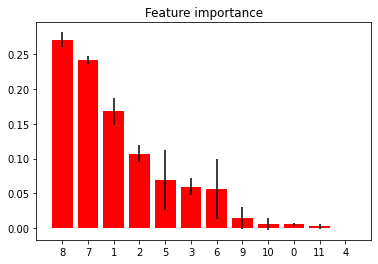

In [17]:
importances = extra_trees.feature_importances_
std = np.std( [tree.feature_importances_ for tree in extra_trees.estimators_], axis=0 ) #calculating the std deviation
indices = np.argsort(importances)[::-1] #trees importance ordered by greater value

# Print feature ranking
print('Feature Ranking:')
df_imp = pd.DataFrame()
for i, j in zip( x_train_n, extra_trees.feature_importances_ ):
    aux = pd.DataFrame( {'feature':i , 'importance': j}, index=[0] )
    df_imp = pd.concat( [df_imp, aux], axis=0 )
    
print(df_imp.sort_values('importance', ascending=False) )

# Plot the imputity-based feature importances of the forest
plt.figure()
plt.title('Feature importance')
plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_n.shape[1]), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()

In [18]:
cols_selected = ['vintage','annual_premium','age', 'region_code','vehicle_damage', 
                 'policy_sales_channel', 'previously_insured']

# using only the selected features to train and test (validation) the model
x_train = df[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

# 3.0. MACHINE LEARNING MODEL

Learning to Rank Evaluation Metrics:

For each model, a Cumulative Gain and Lift curve will be plotted:

- **Cumulative Gain Curve:** ordered by purchase probability, crosses the percentage of the customer base with the percentage of customers likely to buy.

Ex: 20% of the customer base (x), ordered by the purchase probability (y), contains 60% of all interested in vehicle insurance.

- **Lift Curve:** represents the difference between the gain curve and the random list. Therefore, it tells you how much better the model is compared to the random list.

Ex: By approaching 20% of the ordered list, the model is 2,5 times better than the random list.

For each model, Precision and recall at k will also be calculated:

- **Precision at top k:** counts how many predictions were correct up to k, and divides by all predictions made up to k.

**Ex:** Precision at top 10% k = 0.40 - It means that in 10% of the base, the model got 40% right compared to the perfect model, which would get 100% right at top 10%, being there are 12 % of total customers interested (no mistakes up to 12%).

- **Recall at top k:** counts how many predictions were correct up to k, and divides by all true examples.

**Ex:** Recall at top 40% (or 12196) k = 0.8 - It means that 80% of the total interested customers appear in the top-40% results of the ordered list.

## 3.1. KNN

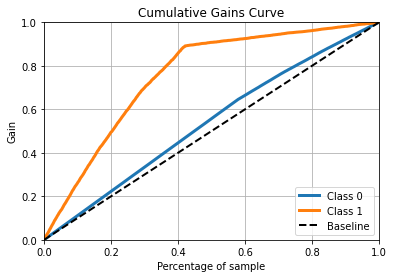

In [19]:
# Model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=8 )

# Model training
knn_model.fit( x_train, y_train.values.ravel() )

# Model prediction (proba)
yhat_knn = knn_model.predict_proba( x_val );

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn);

# What does this chart tell?
# if I make the offer to 40% of the ordered list, i will find ~85% of interested people (with 08 neighbors)
# this means the KNN model left interested people on the end of the list 
# more KNN Neighbors = i will find more interested people

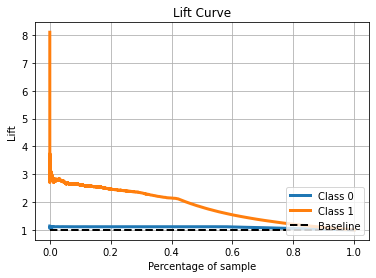

In [20]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_knn);

## 3.2. Logistic Regression

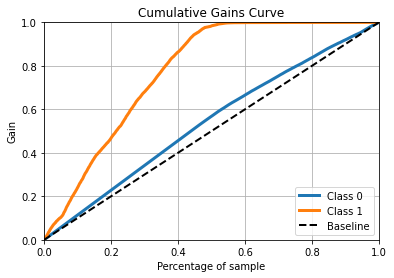

In [21]:
# Model definition
lr_model = lm.LogisticRegression( random_state=42 )
# Model training
lr_model.fit( x_train, y_train.values.ravel() )
# Model prediction (proba)
yhat_lr = lr_model.predict_proba( x_val )

skplt.metrics.plot_cumulative_gain( y_val, yhat_lr);

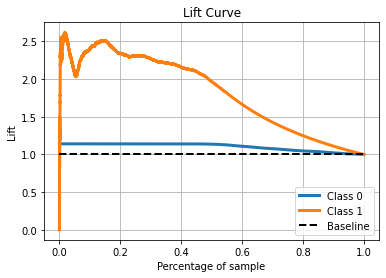

In [22]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr);

## 3.3. Extra Trees

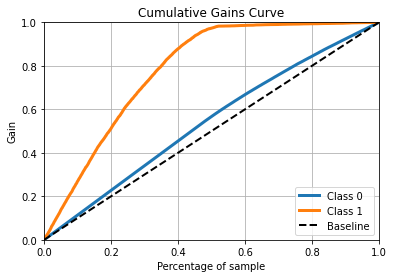

In [23]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=100, random_state=30, n_jobs=-1 )
# model training
et.fit ( x_train, y_train.values.ravel() )
# Model prediction (proba)
yhat_et = et.predict_proba(x_val)

skplt.metrics.plot_cumulative_gain( y_val, yhat_et);

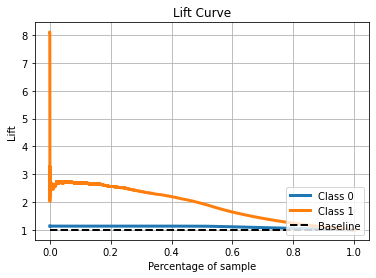

In [24]:
skplt.metrics.plot_lift_curve(y_val, yhat_et);

## 3.4. Random Forest

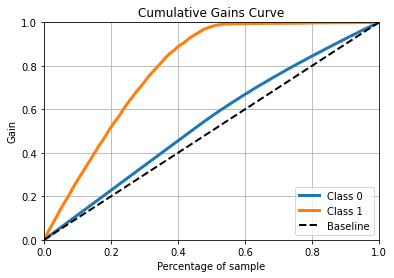

In [25]:
# model definition
rf = en.RandomForestClassifier(n_estimators = 100, n_jobs = -2, random_state = 42)

# model training
rf.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_rf = rf.predict_proba(x_val)

# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

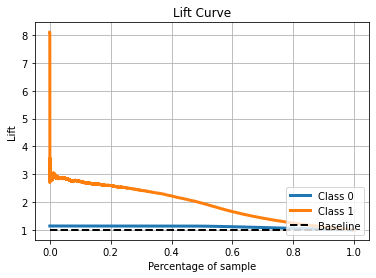

In [26]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_rf);

# 4. MODEL PERFORMANCE

## 4.1. Holdout Validation

In [27]:
# copy data
df_perf = x_validation.copy()
df_perf['response'] = y_validation.copy()

# propensity score - from KNN Model
# yhat = Prediction probabilities for each class returned by a classifier.
df_perf['score_knn'] = yhat_knn[:,1].tolist() # get all propensity score values of response = 1 then converts to list
# yhat is an array resulted from predict_proba methods. This result shows class probabilities which classes in lexicographical order
# source: https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09b/sklearn/neighbors/_classification.py#L240
# In this specific case, the class on position '1' is the response '1'.

# propensity score - from Linear Regression Model
df_perf['score_lr'] = yhat_lr[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# propensity score - from Extra Trees Model
df_perf['score_et'] = yhat_et[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# propensity score - from Random Forest Model
df_perf['score_rf'] = yhat_rf[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# models to evaluate
scores = ['score_knn', 'score_lr', 'score_et', 'score_rf']

# create list to store performance metrics
performance = []

k = 0.4 # sample percentage

for i in scores:
    # compute Precision at k (Precision Top K) = ratio of True Positives within all Positives?
    precision = precision_at_k(df_perf, i, k)

    # compute Recall at k = ratio of True Positives within all instances of the dataset
    recall = recall_at_k(df_perf, i, k)

    # save performance metrics
    performance.append([i, precision, recall, k])

# convert performance metrics list to dataframe
df_perf_rank = pd.DataFrame(performance, columns = ['model', 'precision', 'recall', 'k%'])
df_perf_rank['k%'] = df_perf_rank['k%'] * 100
df_perf_rank = df_perf_rank.round(decimals = {'precision' : 4, 'recall' : 4 , 'k%' : 0}).sort_values('recall', ascending = False).reset_index(drop=True)

df_perf_rank

,model,precision,recall,k%
0,score_rf,0.2741,0.8882,40.0
1,score_et,0.2713,0.8790,40.0
2,score_lr,0.2666,0.8637,40.0
3,score_knn,0.2644,0.8567,40.0


## 4.2. K-Fold Cross Validation

In [28]:
# copy data
X = x_val.copy()
y = y_validation.copy()

# merge data - to unify x_train and x_val (datasets with selected columns from feature selection)
X = pd.concat([X,x_train.copy()], ignore_index = True)
y = pd.concat([y, y_train.copy()], ignore_index = True)

In [29]:
# models definition
knn_model = nh.KNeighborsClassifier(n_neighbors = 7)
lr_model = lm.LogisticRegression(random_state = 42)
rf = en.RandomForestClassifier(n_estimators = 100, n_jobs = -2, random_state = 42)
et = en.ExtraTreesClassifier(n_estimators = 100, n_jobs = -2, random_state = 42)

# models dict
models = {
    'score_knn': knn_model,
    'score_lr': lr_model,
    'score_rf': rf,
    'score_et': et
}

# K-Fold number
kfolds = 5
kf = ms.KFold(n_splits = kfolds)

# Precision & Recall at k (in percentage of dataset):
k = 0.4

# Store Precision and Recall at k for all models
perf_metrics = []

# loop through every ML model (i = keys = model name | model = model definition)
for i, model in models.items(): 
    
    performance = []

    for train, test in kf.split(X, y): # returns an array of train and test indexes

        # model training
        model.fit(X.iloc[train], y.iloc[train])

        # model prediction - Generalizing Power
        yhat = model.predict_proba(X.iloc[test])

        # test dataset
        df_perf = X.iloc[test].copy()
        df_perf['response'] = y.iloc[test].copy()

        # propensity score
        df_perf[i] = yhat[:,1].tolist() # get all propensity score values of response = 1 then converts to list

        # compute Precision at k (Precision Top K) = ratio of True Positives within all Positives?
        precision = precision_at_k(df_perf, i, k)

        # compute Recall at k = ratio of True Positives within all instances of the dataset
        recall = recall_at_k(df_perf, i, k)

        # save performance metrics
        performance.append([i, precision, recall, k])


    # After cross-validation of ONE model, compute mean and std. Then store the results:

    # convert performance metrics from ONE model to dataframe
    rank = pd.DataFrame(performance, columns = ['model', 'precision', 'recall', 'k%'])
    rank['k%'] = rank['k%'] * 100

    # perf_metrics = [] # this should be outside models LOOP
    precision_mean = round(rank['precision'].mean(), 4)
    precision_std = round(rank['precision'].std(), 4)
    recall_mean = round(rank['recall'].mean(), 4)
    recall_std = round(rank['recall'].std(), 4)
    perf_metrics.append([i, kfolds, k, precision_mean, precision_std, recall_mean, recall_std])


# this should be outside models LOOP:
perf_metrics_df = pd.DataFrame(perf_metrics, columns = ['model', 'k_folds', 'k', 'precision_at_k_mean', 'precision_at_k_std', 'recall_at_k_mean', 'recall_at_k_std'])
perf_metrics_df

,model,k_folds,k,precision_at_k_mean,precision_at_k_std,recall_at_k_mean,recall_at_k_std
0,score_knn,5,0.4,0.2633,0.0040,0.8594,0.0027
1,score_lr,5,0.4,0.2666,0.0030,0.8702,0.0064
2,score_rf,5,0.4,0.2734,0.0039,0.8922,0.0036
3,score_et,5,0.4,0.2696,0.0034,0.8798,0.0030


In [30]:
perf_metrics_df.sort_values('recall_at_k_mean', ascending = False)

,model,k_folds,k,precision_at_k_mean,precision_at_k_std,recall_at_k_mean,recall_at_k_std
2,score_rf,5,0.4,0.2734,0.0039,0.8922,0.0036
3,score_et,5,0.4,0.2696,0.0034,0.8798,0.0030
1,score_lr,5,0.4,0.2666,0.0030,0.8702,0.0064
0,score_knn,5,0.4,0.2633,0.0040,0.8594,0.0027


 
# 5. Saving Models


In [31]:
# I choose the Linear Regression model because it performed well and it is ligher than Random forest
pickle.dump(lr_model, open('/home/rafael/Repos/cross_sell_prediction/model/Health_Insurance.pkl', 'wb'))